# Paper Abstracts Clustering - 2nd

Author: Rafael Ballestiero

In [1]:
import os

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[50,30]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

In [4]:
from gensim.models import KeyedVectors

from gensim.utils import has_pattern, simple_preprocess
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords

from gensim.scripts.glove2word2vec import glove2word2vec

from gensim.summarization import keywords, summarize_corpus, summarize
from gensim.summarization.textcleaner import clean_text_by_sentences
from gensim.test.utils import datapath, get_tmpfile

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder

from scipy import spatial
import scipy.cluster.hierarchy as shc

from pyemd import emd

assert has_pattern()

### Clean

Assuming the dataset provided is well defined, each reference should have a description (1-1 matching). Given that there are 385 rows in the dataset, there must be some inconsistencies that need addressing.

In [5]:
raw_data = pd.read_excel("./data/abstracts_second_list.xlsx", header=None, index_col=None)[0]

XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'Year,Ref'

In [4]:
year_with_dot_regex = re.compile("\([0-9]{4}\)\.")
reference_rows = raw_data[raw_data.apply(lambda x: re.search(year_with_dot_regex, x) is not None)]

In [5]:
pd.Series(reference_rows.index.tolist()).diff().where(lambda x: x != 2).dropna()

78     1.0
122    1.0
123    1.0
149    1.0
150    1.0
dtype: float64

In [6]:
reference_rows.loc[152:158]

152    Ian Stuart, F. (1998). The influence of organi...
154    Iriarte, I., Hoveskog, M., Justel, D., Val, E....
155    Iriarte, I., Justel, D., Alberdi, A., Val, E.,...
157    Jaaron, A. A.  ., & Backhouse, C. J. (2018). O...
Name: 0, dtype: object

In [130]:
reference_rows = reference_rows.drop(reference_rows.reindex(range(385)).isna().astype('int').diff().where(lambda s: abs(s) != 1).dropna().index)

Above, we can see an example of a reference for which we don't have a description. There are 5 such references. We will disregard these, meaning that we should have a total of 190 descriptions which is indeed the case.

In [7]:
descriptions = raw_data[~raw_data.index.isin(reference_rows.index)].reset_index(drop=True)
descriptions.shape

(190,)

In [120]:
processed_abstracts = descriptions.apply(lambda x: x.lower()).apply(remove_stopwords).apply(simple_preprocess)

#### Convert GloVe to Word2Vec

In [126]:
def convert_glove_2_w2v():
    tmp_file = get_tmpfile("test_word2vec.txt")

    glove2word2vec("./data/glove.6B/glove.6B.50d.txt", tmp_file)

    return KeyedVectors.load_word2vec_format(tmp_file)
    
model = convert_glove_2_w2v()

In [128]:
def abstract_distance_matrix():
    s = processed_abstracts.size
    result = np.ndarray((s,s))
    
    for i, abstract in enumerate(processed_abstracts):
        print(f"({i}/{s}) Running abstract: {abstract}")
        
        result[i] = processed_abstracts.apply(lambda x: model.wmdistance(abstract, x))
        
        print(f"({i}/{s}) Finished running abstract.\n{result[i]}")
            
    return result
    return np.array([[model.wmdistance(processed_abstracts[i], processed_abstracts[j]) for i in range(s)] for j in range(s)])

abstract_distance_matrix = abstract_distance_matrix()

(0/190) Running abstract: ['paper', 'extend', 'understanding', 'innovation', 'service', 'ecosystems', 'focussing', 'role', 'values', 'resonance', 'relation', 'integration', 'brands', 'service', 'systems', 'experience', 'rooms', 'empirical', 'explorative', 'case', 'study', 'innovative', 'service', 'carried', 'narrative', 'approach', 'presented', 'form', 'saga', 'insights', 'gleaned', 'empirical', 'study', 'conceptual', 'developments', 'analysis', 'empirical', 'case', 'study', 'presented', 'lessons', 'linked', 'values', 'brands', 'service', 'systems', 'experience', 'rooms', 'paper', 'extends', 'conceptual', 'framework', 'innovative', 'resource', 'integration', 'service', 'ecosystems', 'paper', 'contributes', 'propositions', 'inform', 'theory', 'values', 'resonance', 'basis', 'service', 'innovation', 'innovative', 'integration', 'brands', 'based', 'values', 'resonance', 'foster', 'innovation', 'integration', 'resources', 'service', 'boundaries', 'grounded', 'values', 'resonance', 'enable'

In [8]:
# pd.DataFrame(abstract_distance_matrix).to_csv('data/second_abstract_distance_matrix.csv')
abstract_distance_matrix = pd.read_csv('data/second_abstract_distance_matrix.csv', index_col=0).values
abstract_df = spatial.distance.squareform(np.round(abstract_distance_matrix, 3))

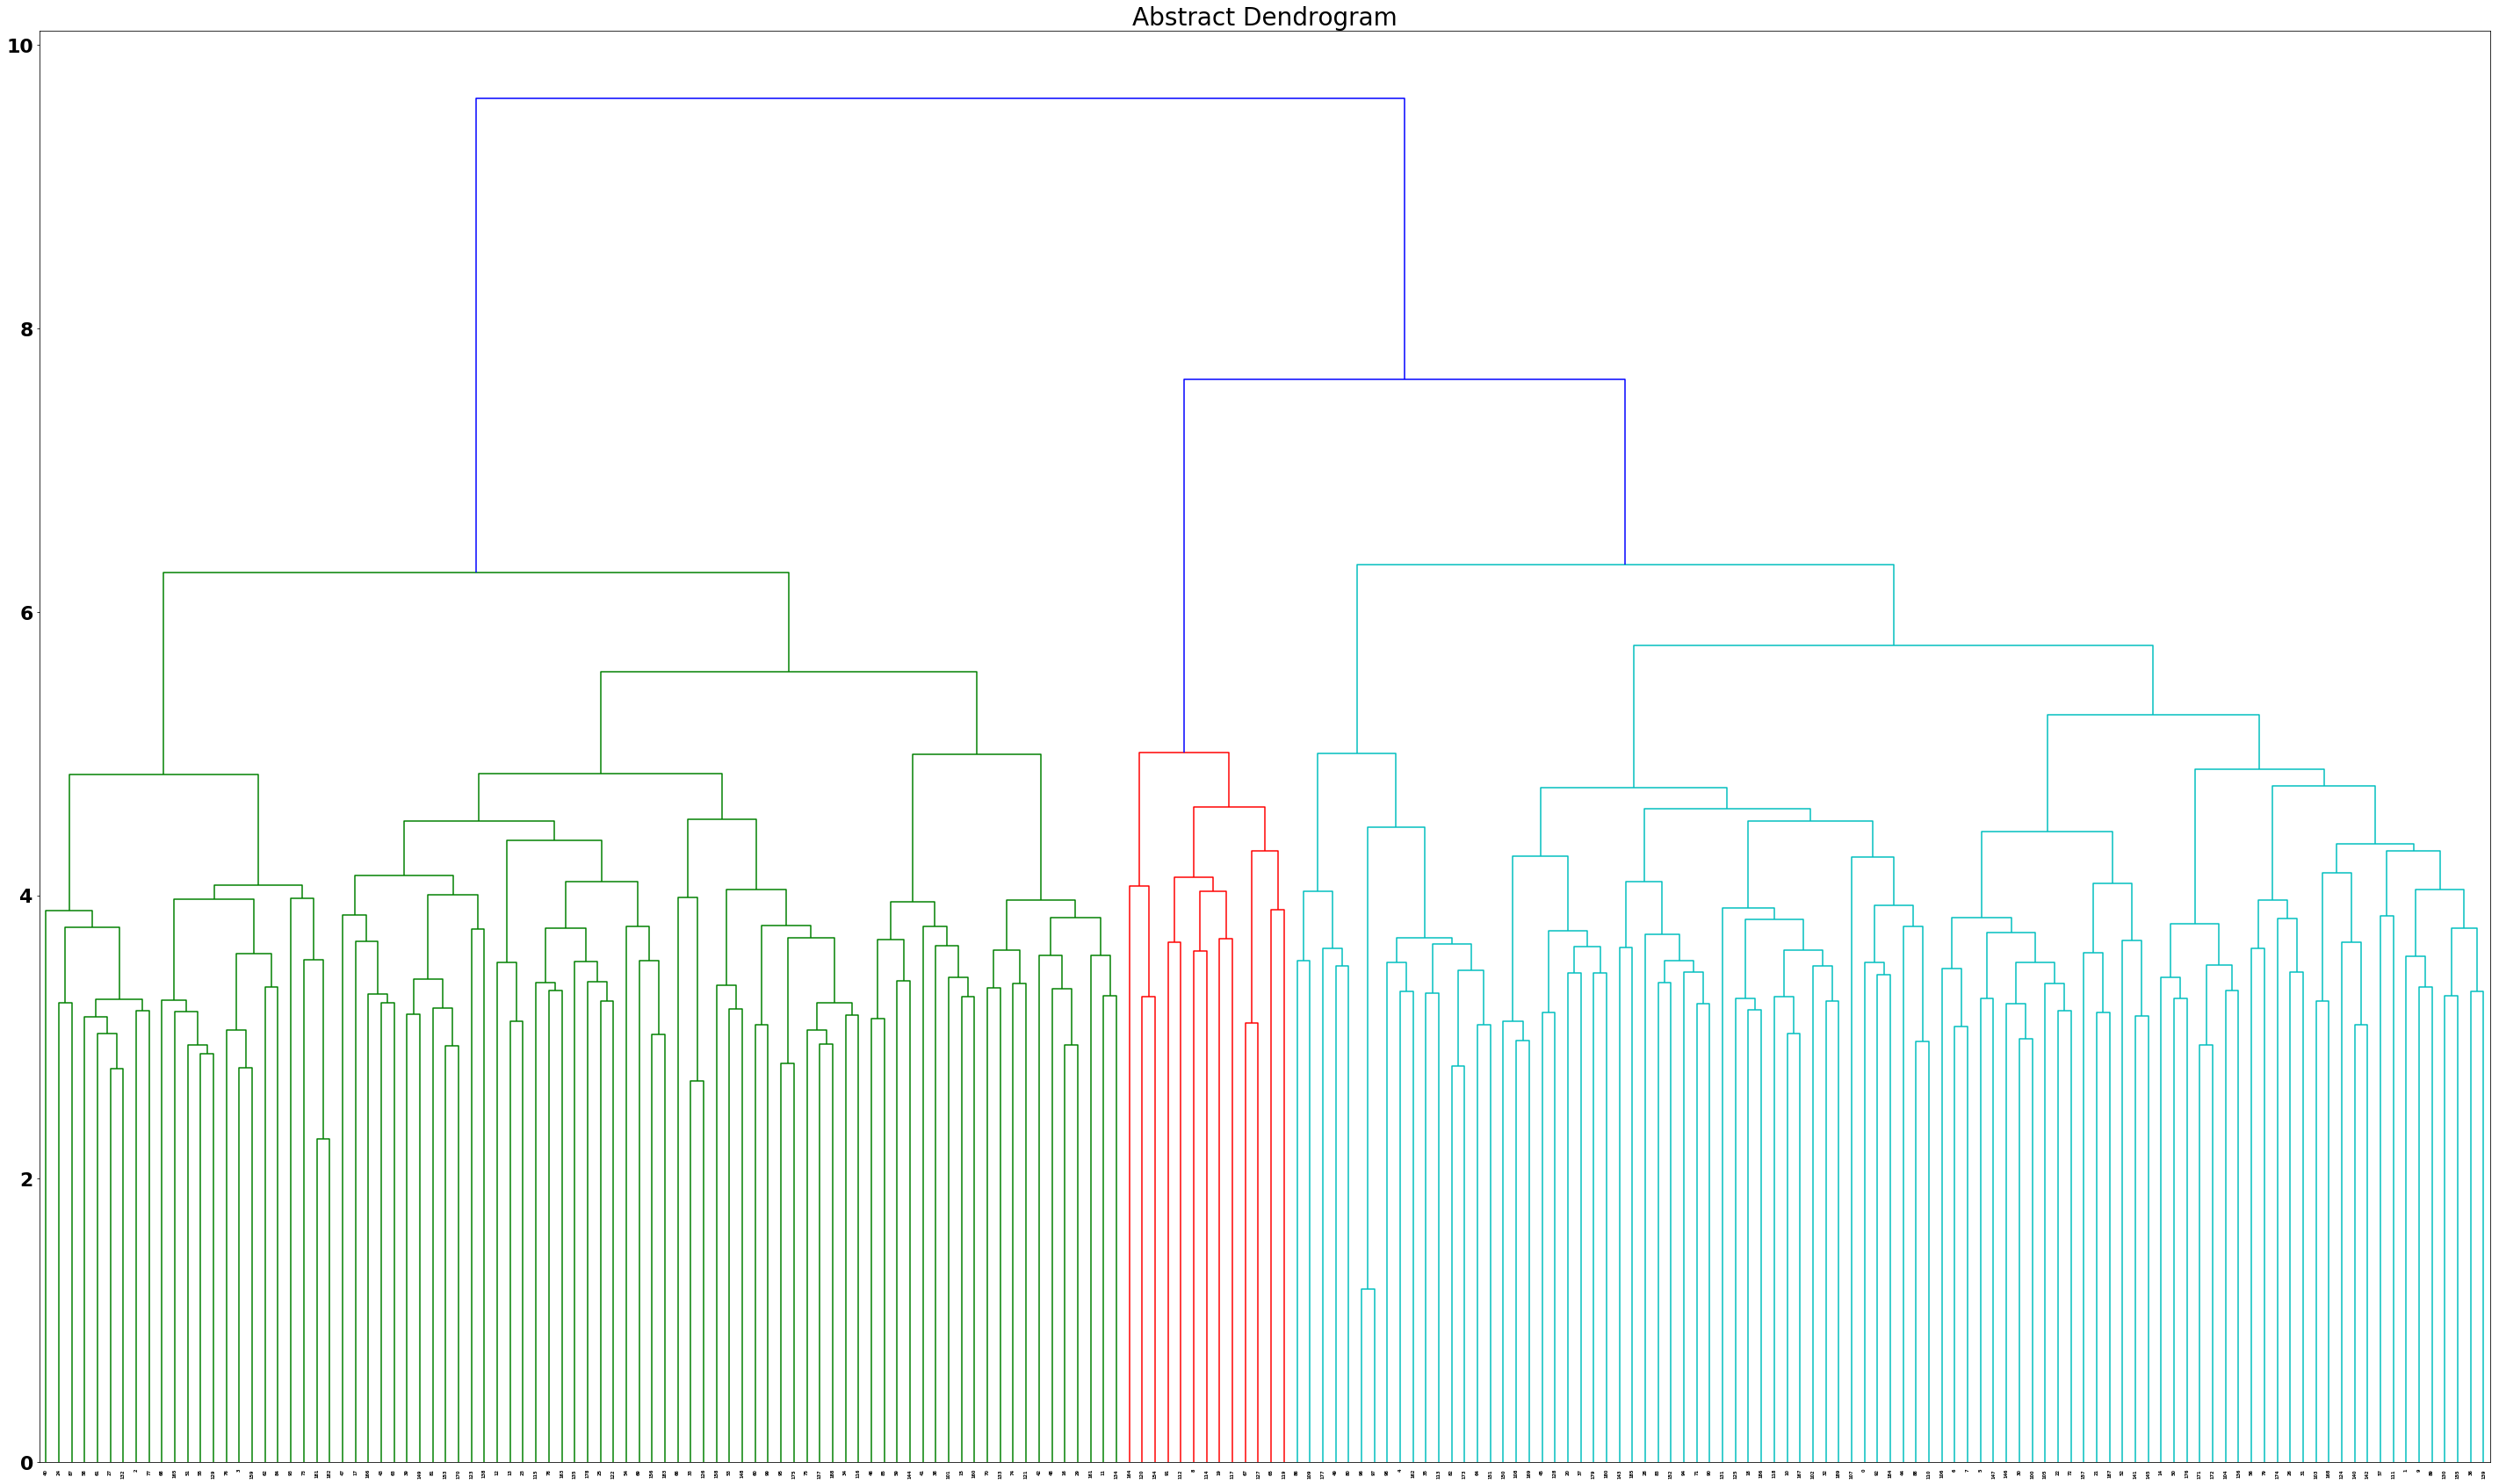

In [11]:
plt.title("Abstract Dendrogram")
dend = shc.dendrogram(shc.linkage(abstract_df, method='ward'))
plt.savefig('plots/dendrograms/abstract_dendrogram.pdf', format='pdf')

In [12]:
def cluster(X, n_clusters):
    return shc.fcluster(shc.linkage(X, method='ward'), n_clusters, criterion='maxclust')

In [13]:
def silhouette_evaluation(X, n_clusters, name, squareform=False):
    fig, ax1 = plt.subplots(figsize=(30, 15))

    clusters = cluster(X, n_clusters)
    
    if squareform:
        X = spatial.distance.squareform(X)

    silhouette_avg = silhouette_score(X, clusters, sample_size=None)
    samples = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(1, n_clusters + 1):
        cluster_silhouette_scores = samples[clusters == i]
        cluster_silhouette_scores.sort()

        cluster_size = cluster_silhouette_scores.shape[0]
        y_upper = y_lower + cluster_size

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f'Silhouette Graph (k={n_clusters}) - {name}')

    ax1.set_yticks([])
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.text(silhouette_avg + 0.01,20,f'silhouette_avg={np.round(silhouette_avg, 4)}')
    plt.savefig(f'plots/silhouette/{name}/silhouette_{n_clusters}')
    plt.show()

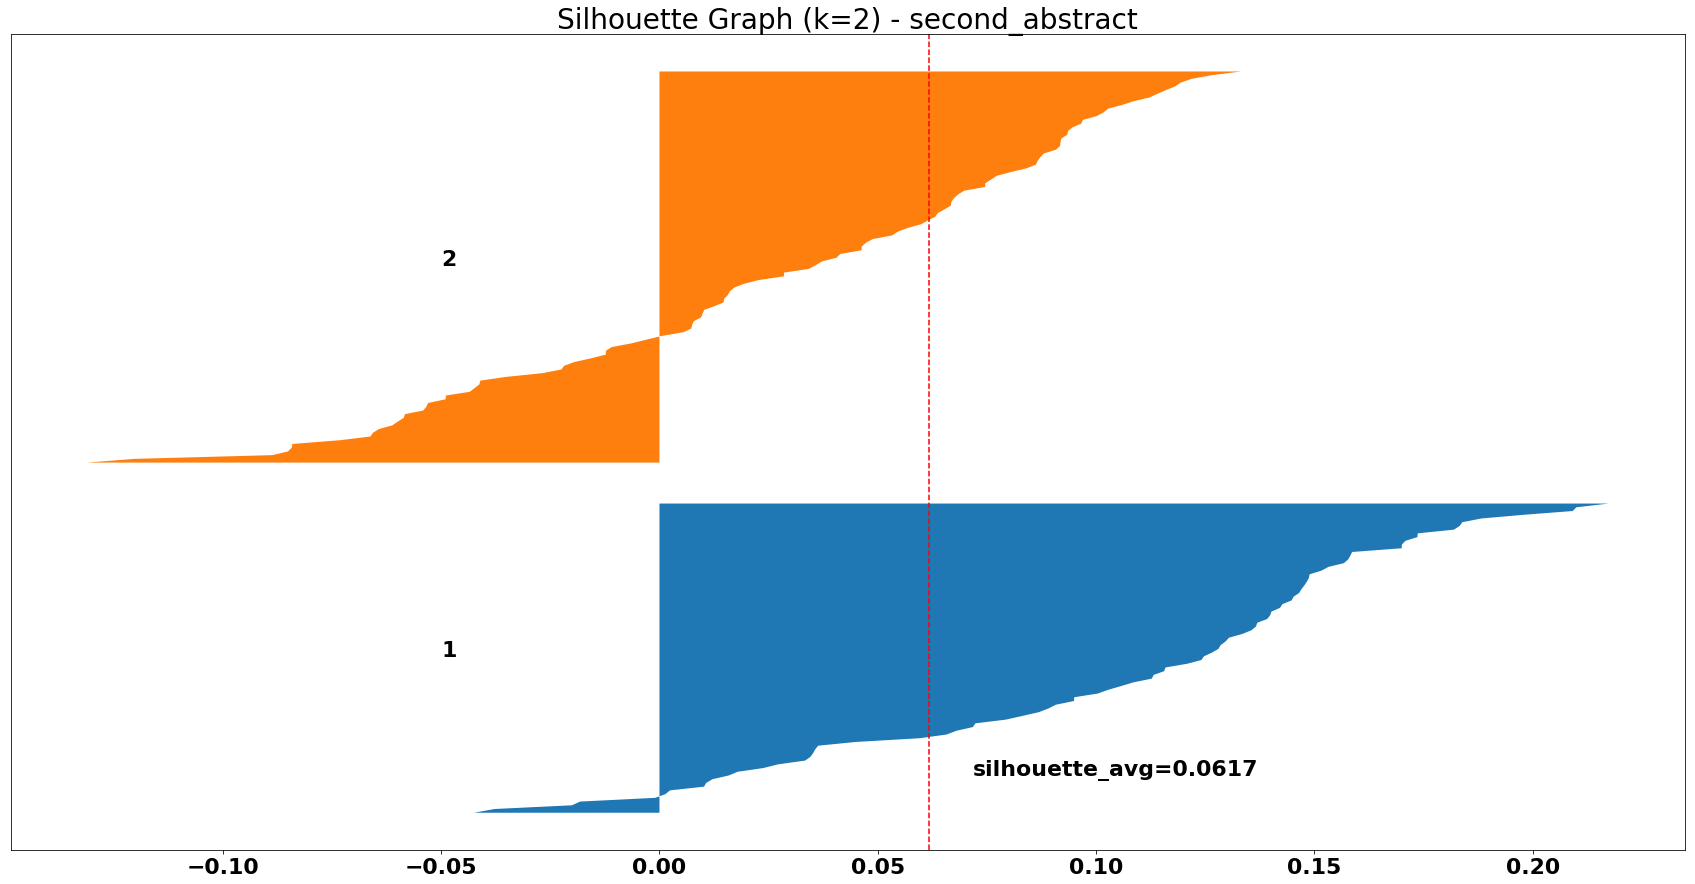

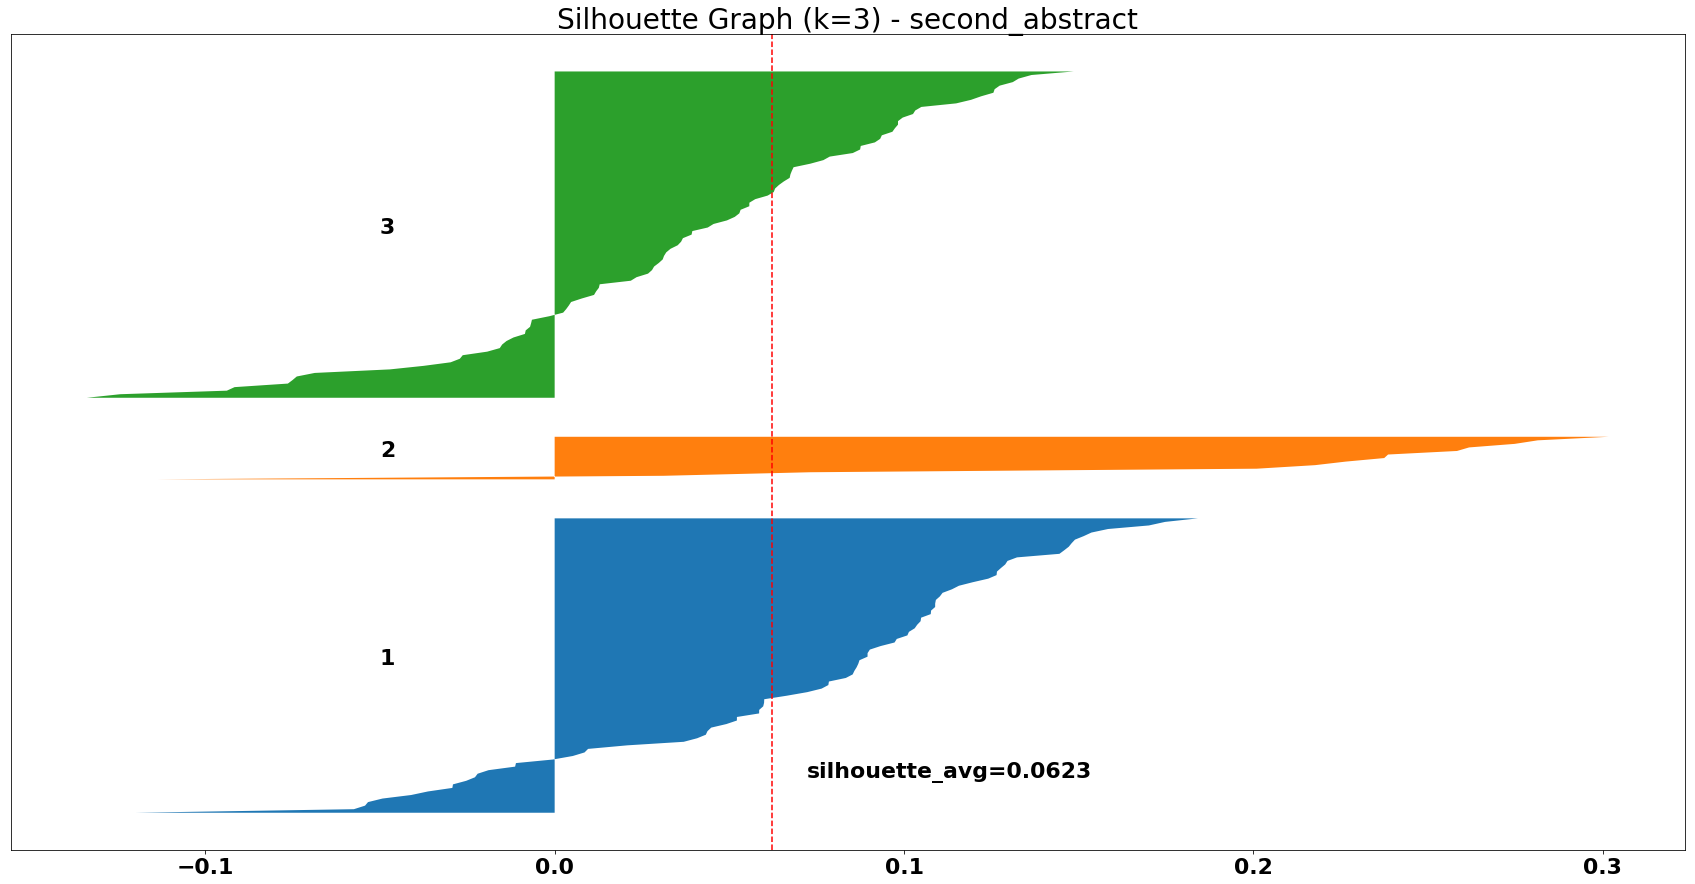

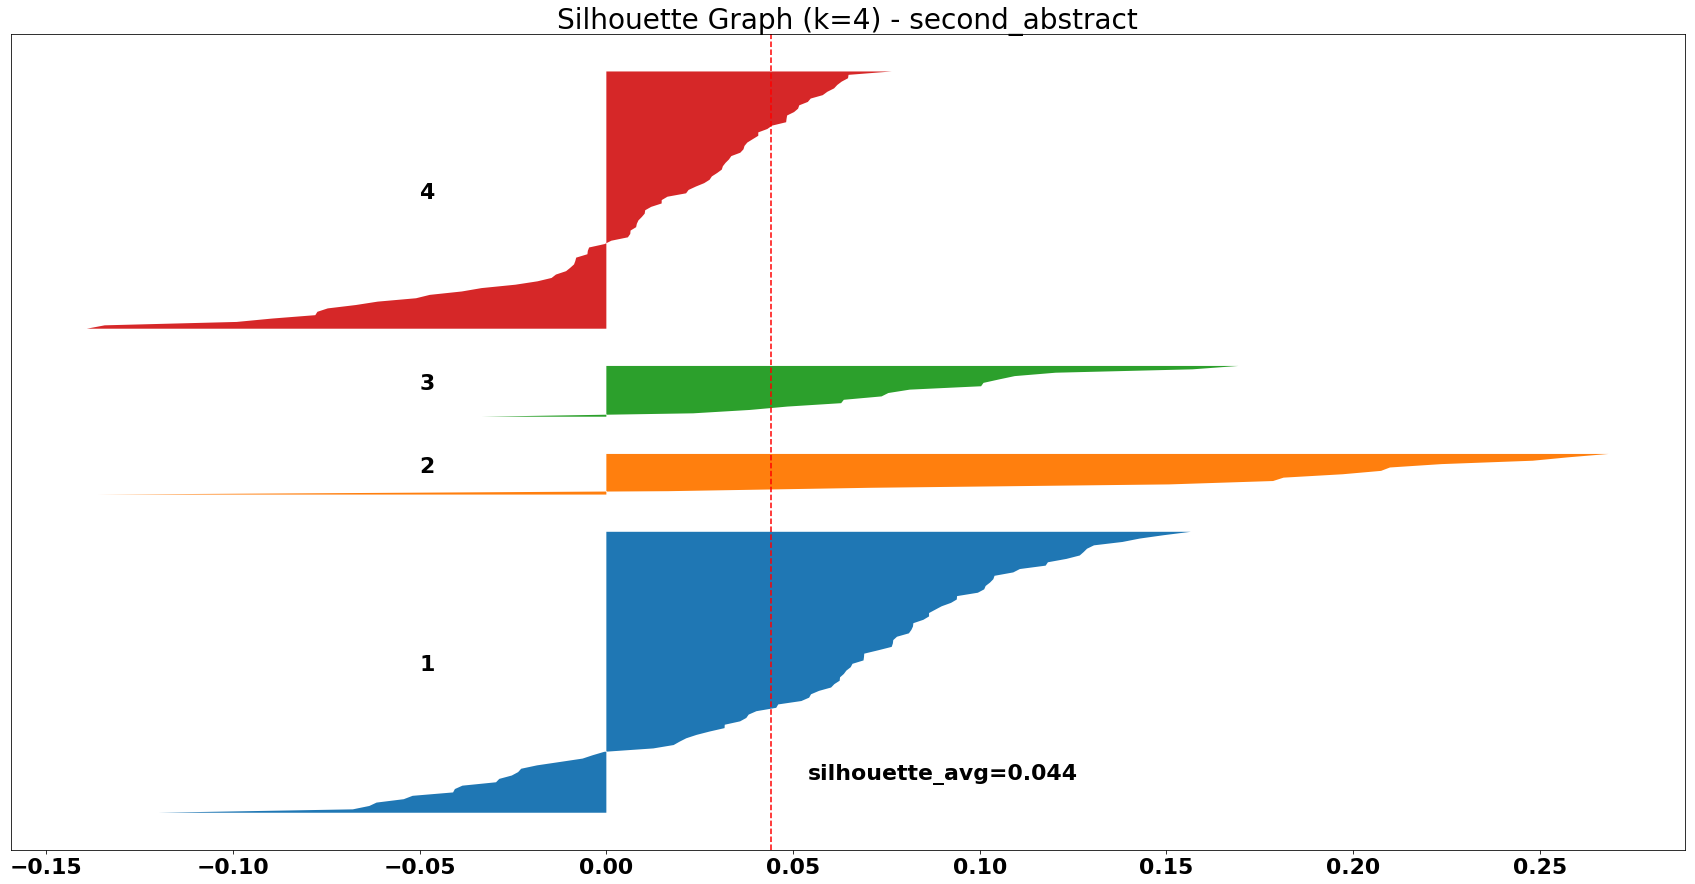

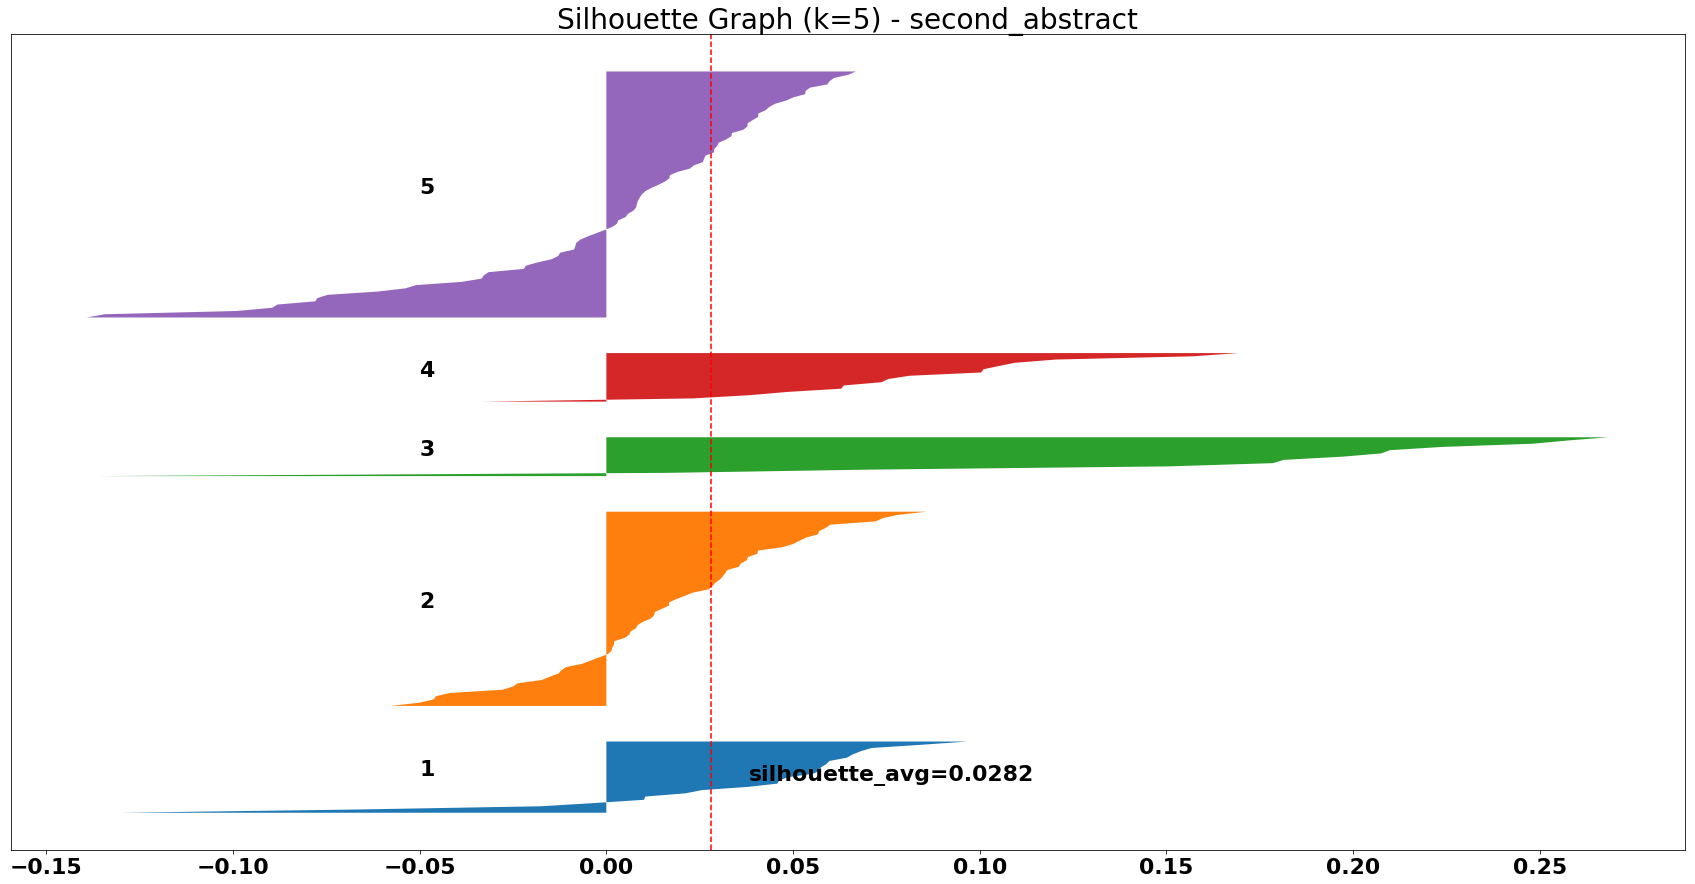

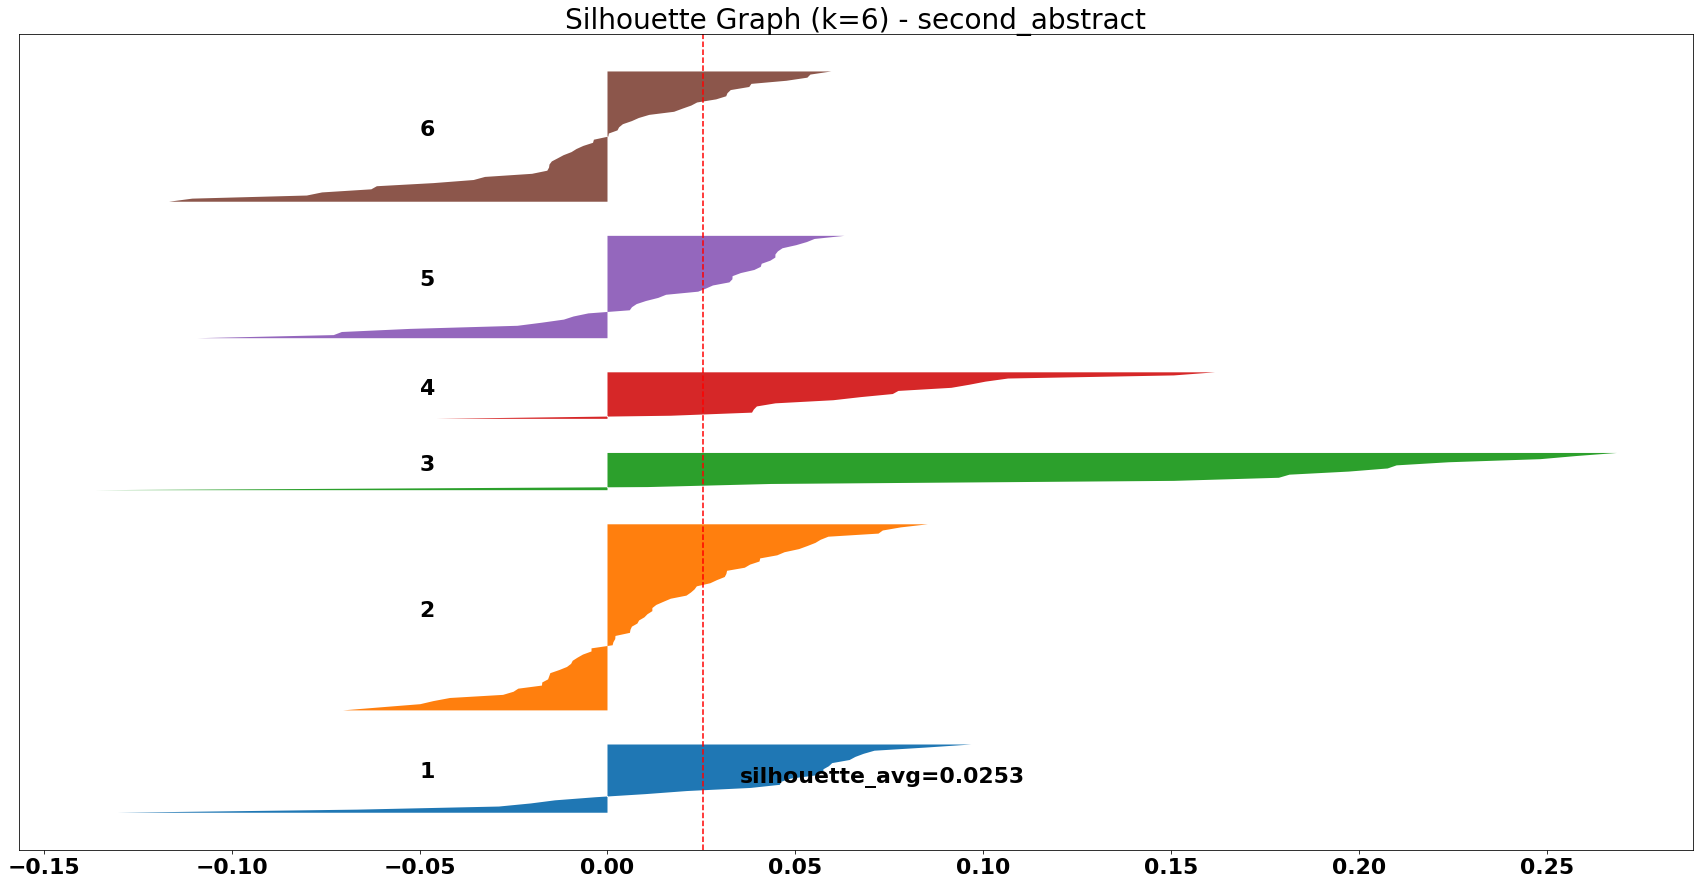

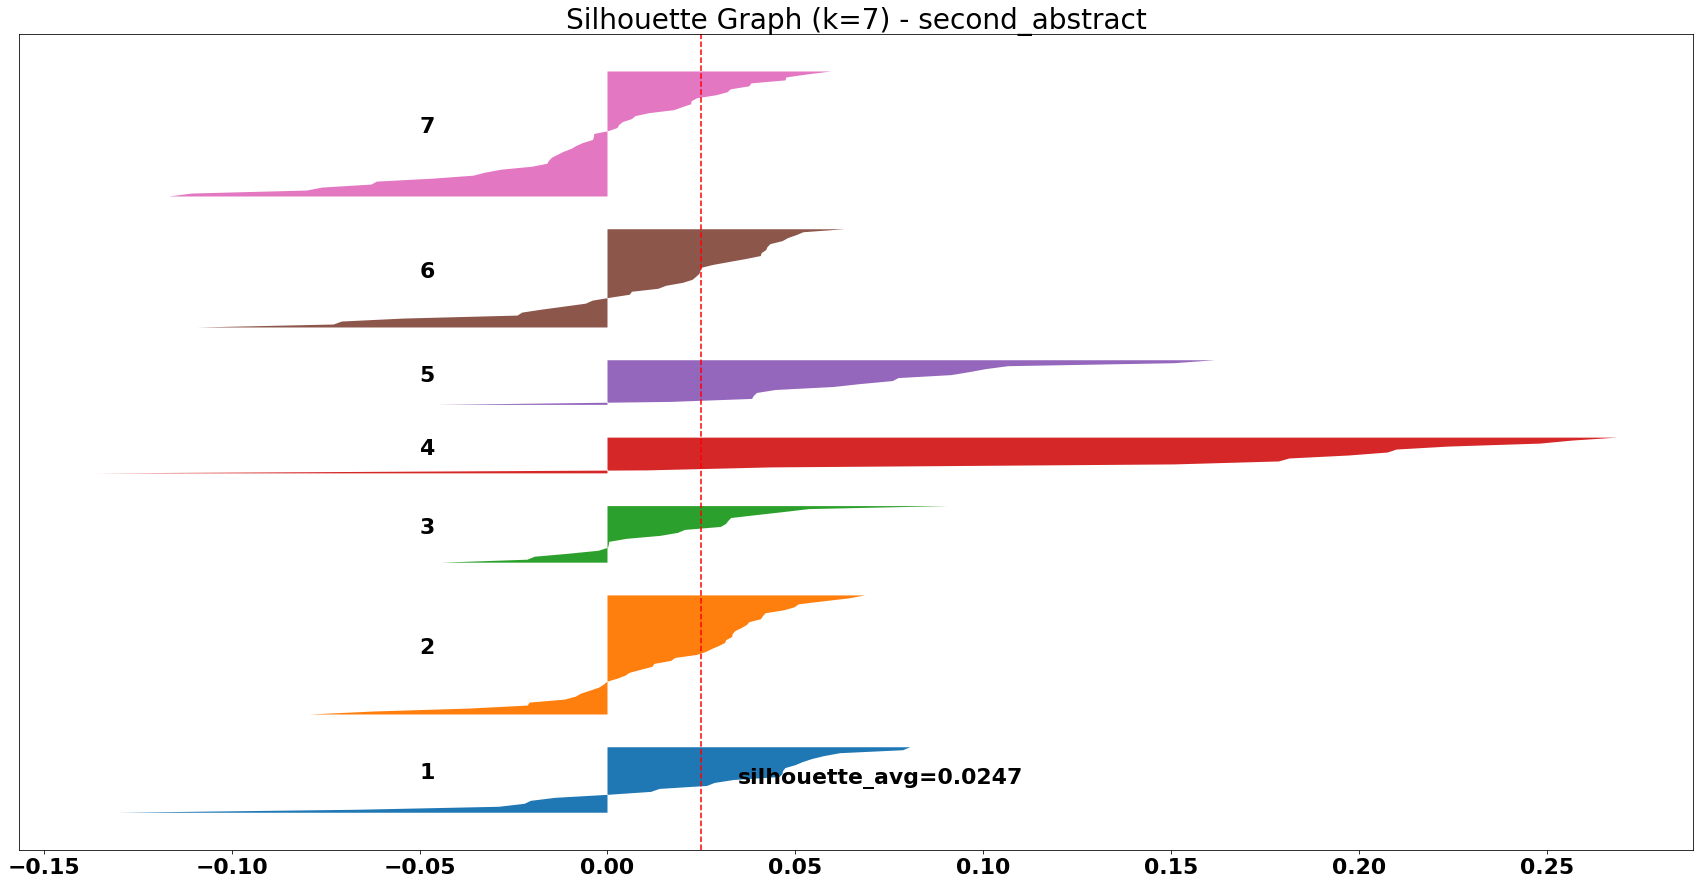

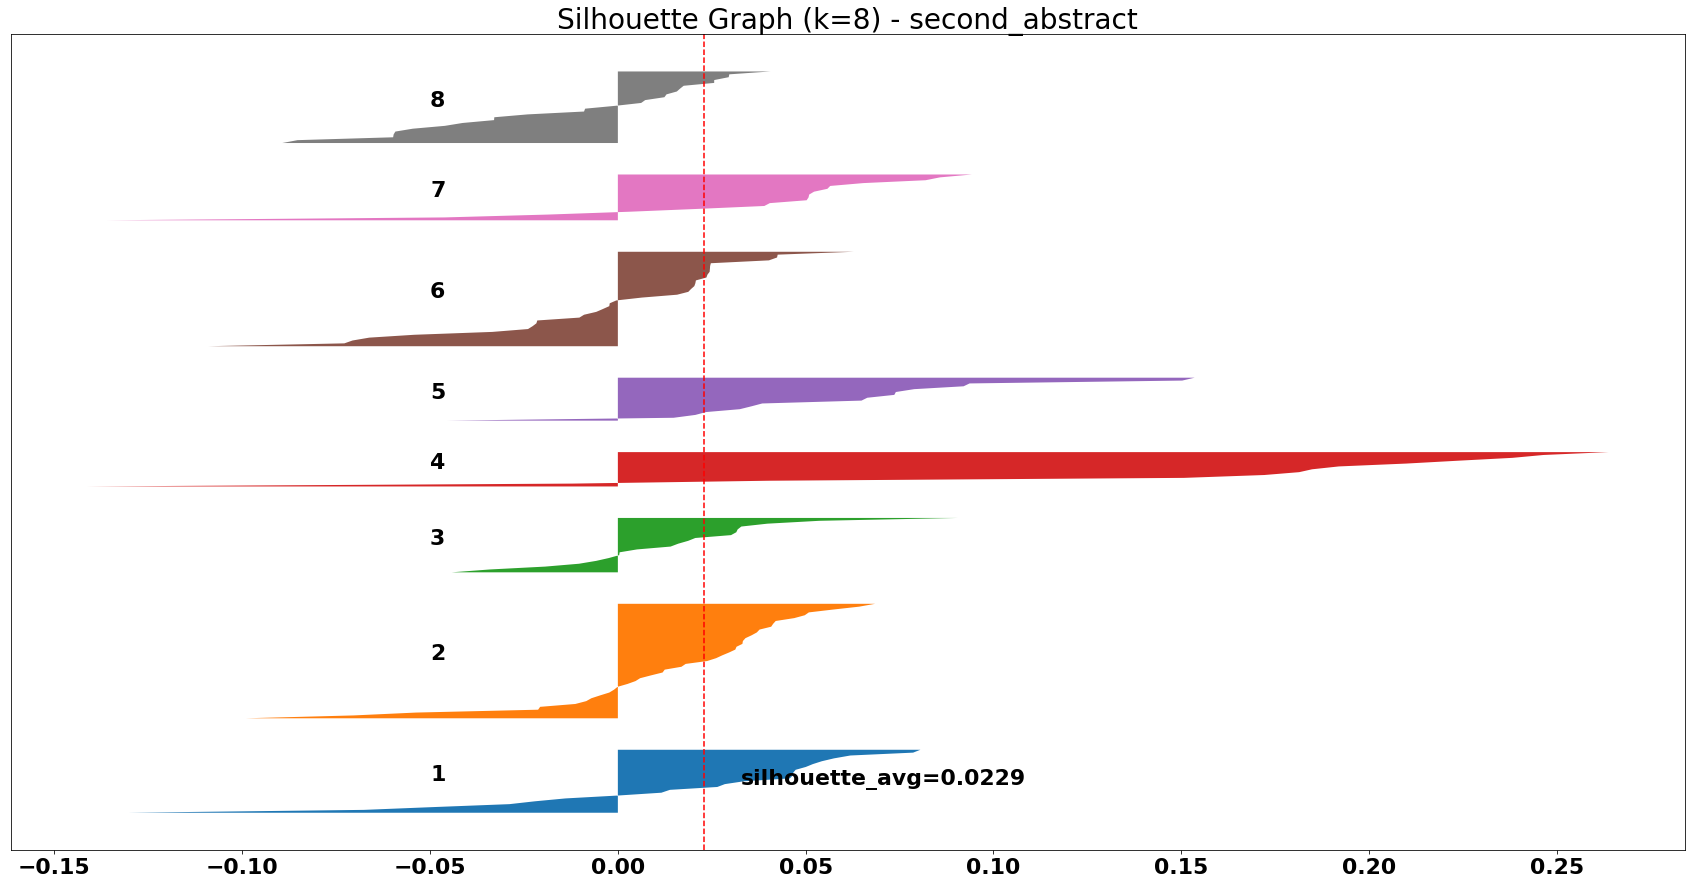

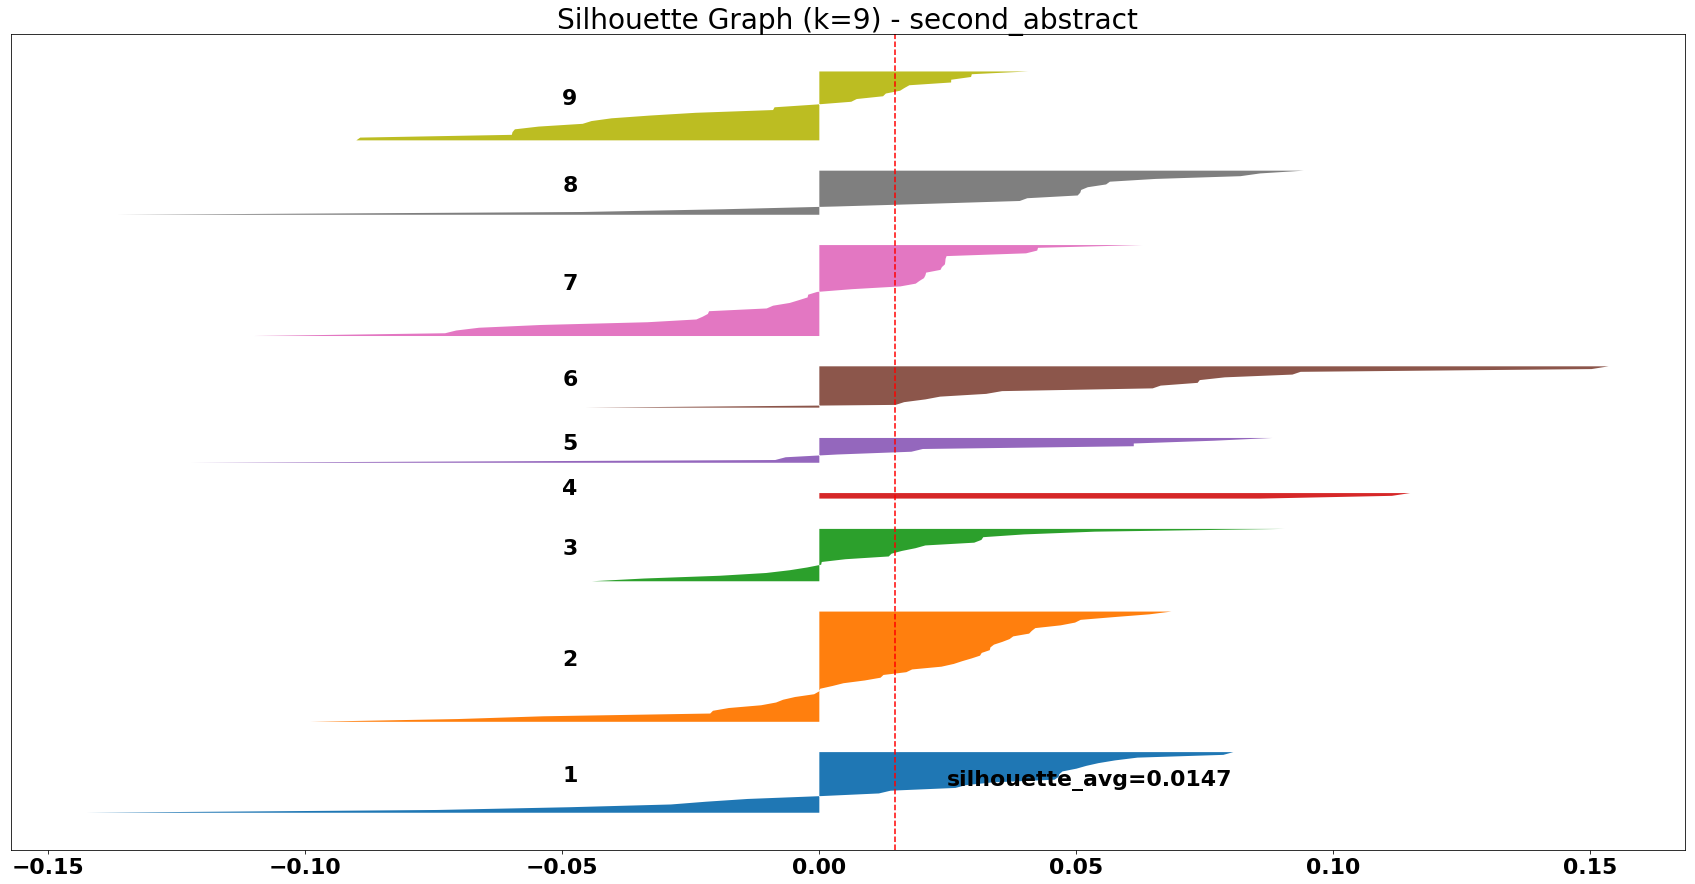

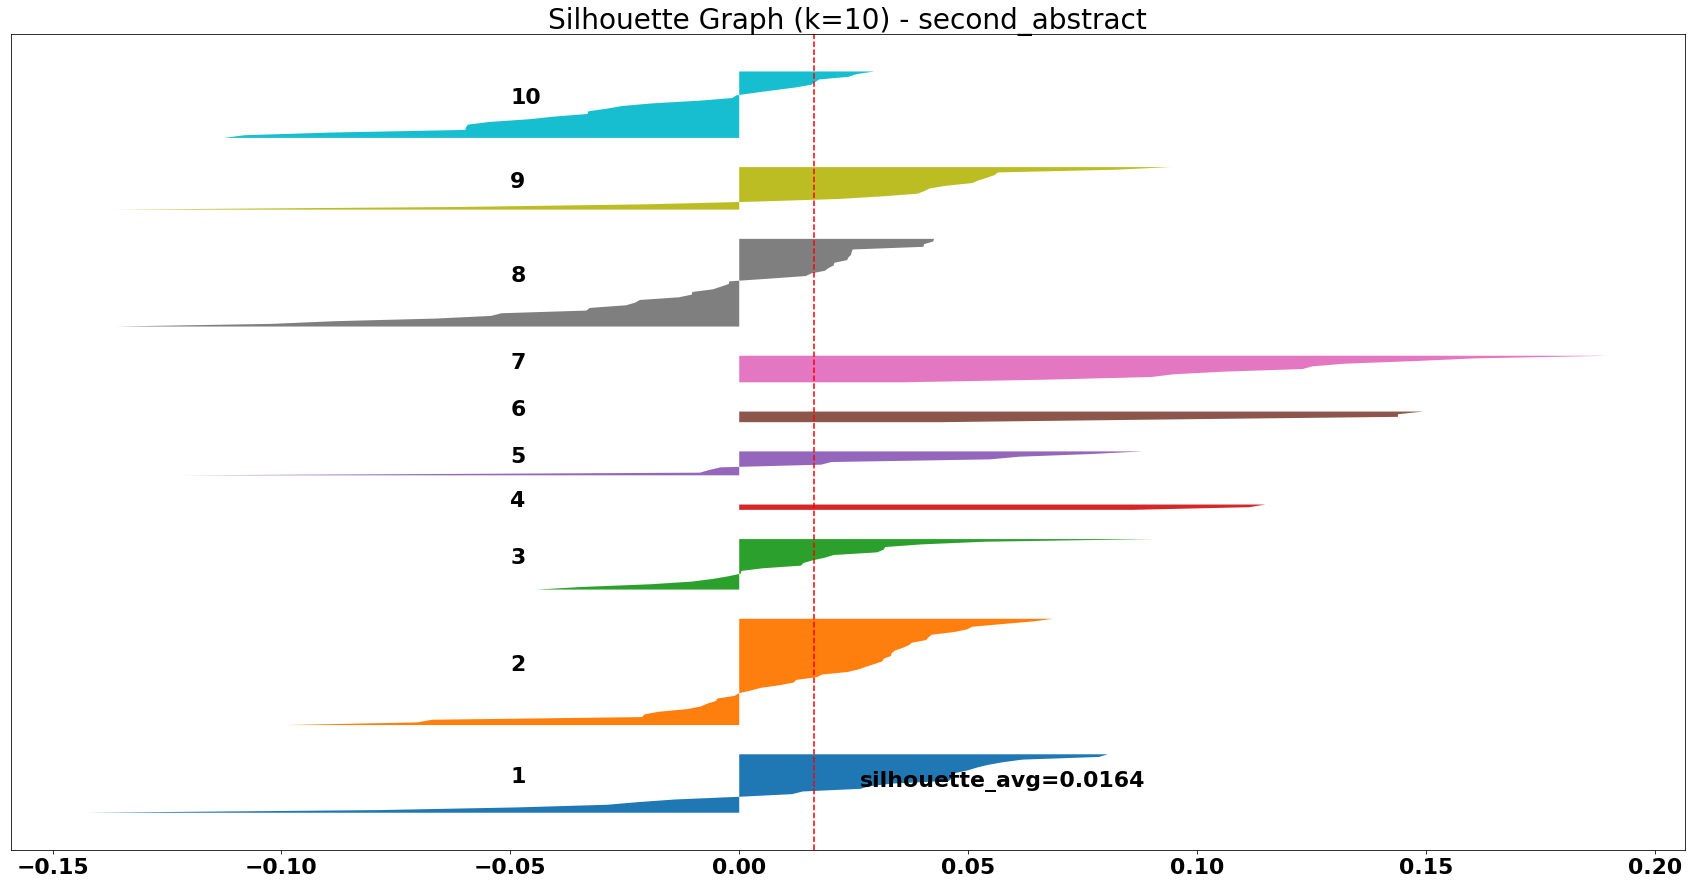

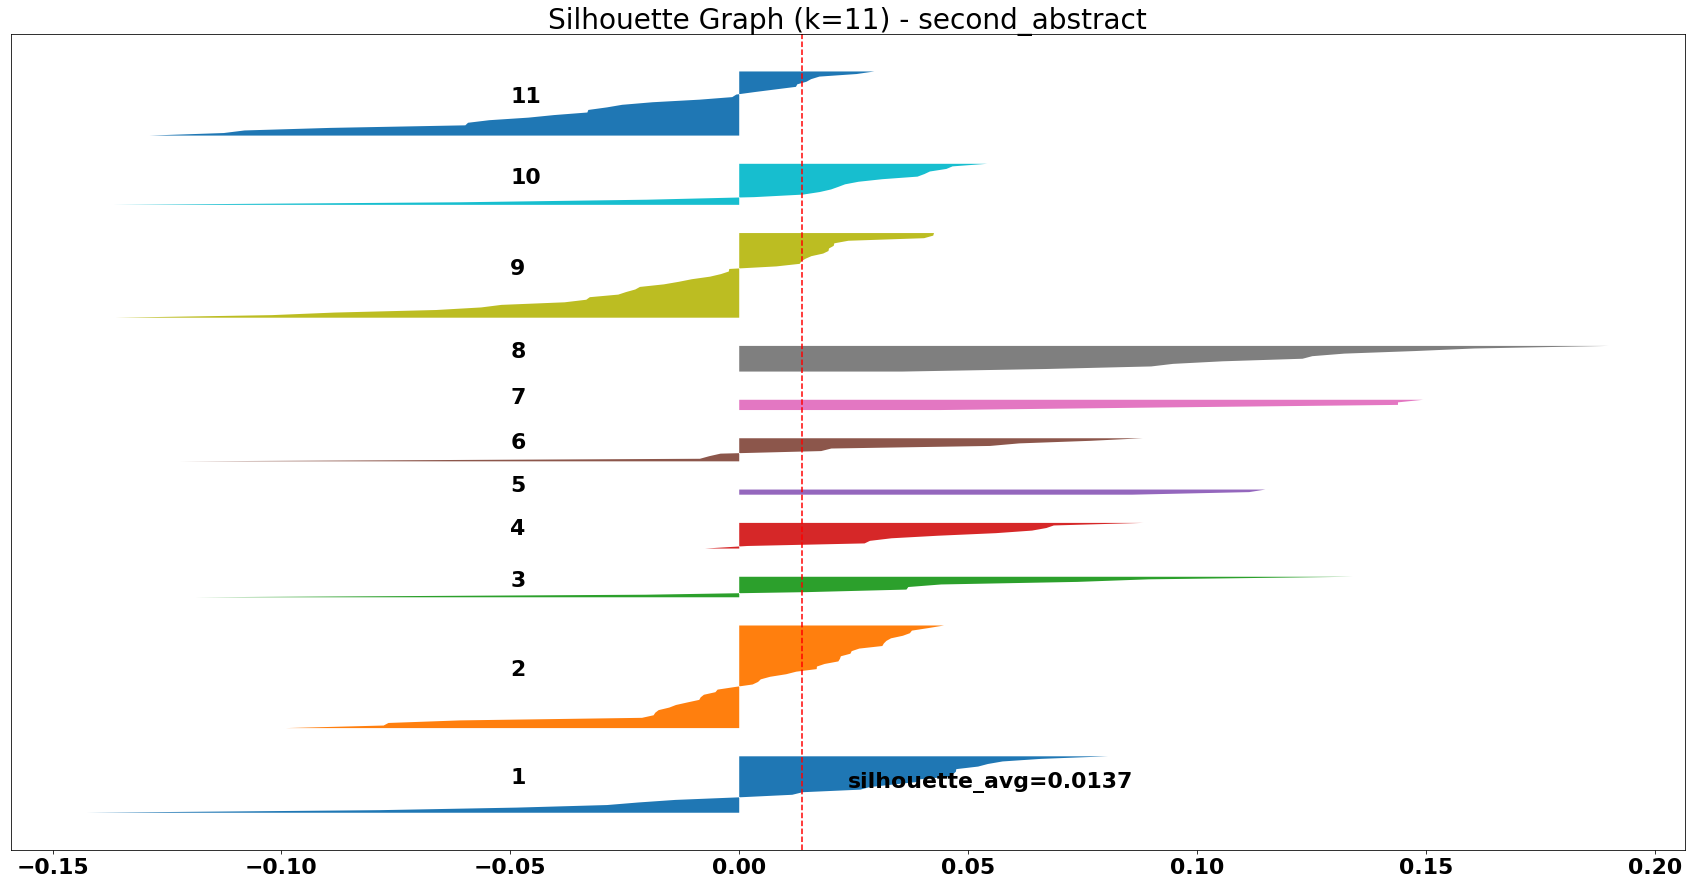

In [150]:
for i in range(2, 12):
    silhouette_evaluation(abstract_df, i, "second_abstract", True)

In [111]:
def cluster_keyword_scores(clusters, score_threshold=0.1, common_words=[]):
    result = []
    
    scored_keywords = descriptions.groupby(clusters)\
                                  .apply("\n".join)\
                                  .apply(simple_preprocess)\
                                  .apply(lambda x: [w for w in x if w not in common_words])\
                                  .apply(" ".join)\
                                  .apply(lambda x: keywords(x, lemmatize=True, scores=True, words=5, pos_filter=('NN',)))

    for i, (group, kw_list) in enumerate(scored_keywords.iteritems()):
        for keyword, score in kw_list:
            if score >= score_threshold:
                result.append((group, keyword, score))
            
    return pd.DataFrame(result, columns=["cluster", "keyword", "score"])

In [112]:
def plot_cluster_keywords(X, n_clusters, title, **kwds):
    X_scores = cluster_keyword_scores(cluster(X, n_clusters), **kwds)
    
    fig, axes = plt.subplots(nrows=n_clusters, sharey=True)
        
    fig.suptitle(title, fontsize=35)
    fig.set_figheight(50)
    
    for i, ax in enumerate(axes):
        cluster_num = i + 1
        
        sns.barplot(
            x='keyword',  
            y='score',  
            data=X_scores[X_scores['cluster'] == cluster_num],
            ax=ax
        )

        ax.set_title(f"cluster={cluster_num}")
        ax.set_xlabel(None)
        ax.tick_params(axis='x', labelsize=40)
        
    
    fig.savefig(f'plots/keywords/second_{title}.pdf', format='pdf')
    

In [132]:
c5 = cluster(abstract_df, 5)
c6 = cluster(abstract_df, 6)
c7 = cluster(abstract_df, 7)

In [103]:
summaries = descriptions.groupby(c5).apply(". ".join).apply(lambda x: summarize(x, word_count=50))

In [106]:
summaries.iloc[3]

'. Despite the noteworthy changes towards product-service system(PSS) as a survival strategy of firms, literature has not fully supported PSS innovation due to some limitations: little attention to technology as an innovation source, absence of available data, and lack of quantitative methodology.'

[]


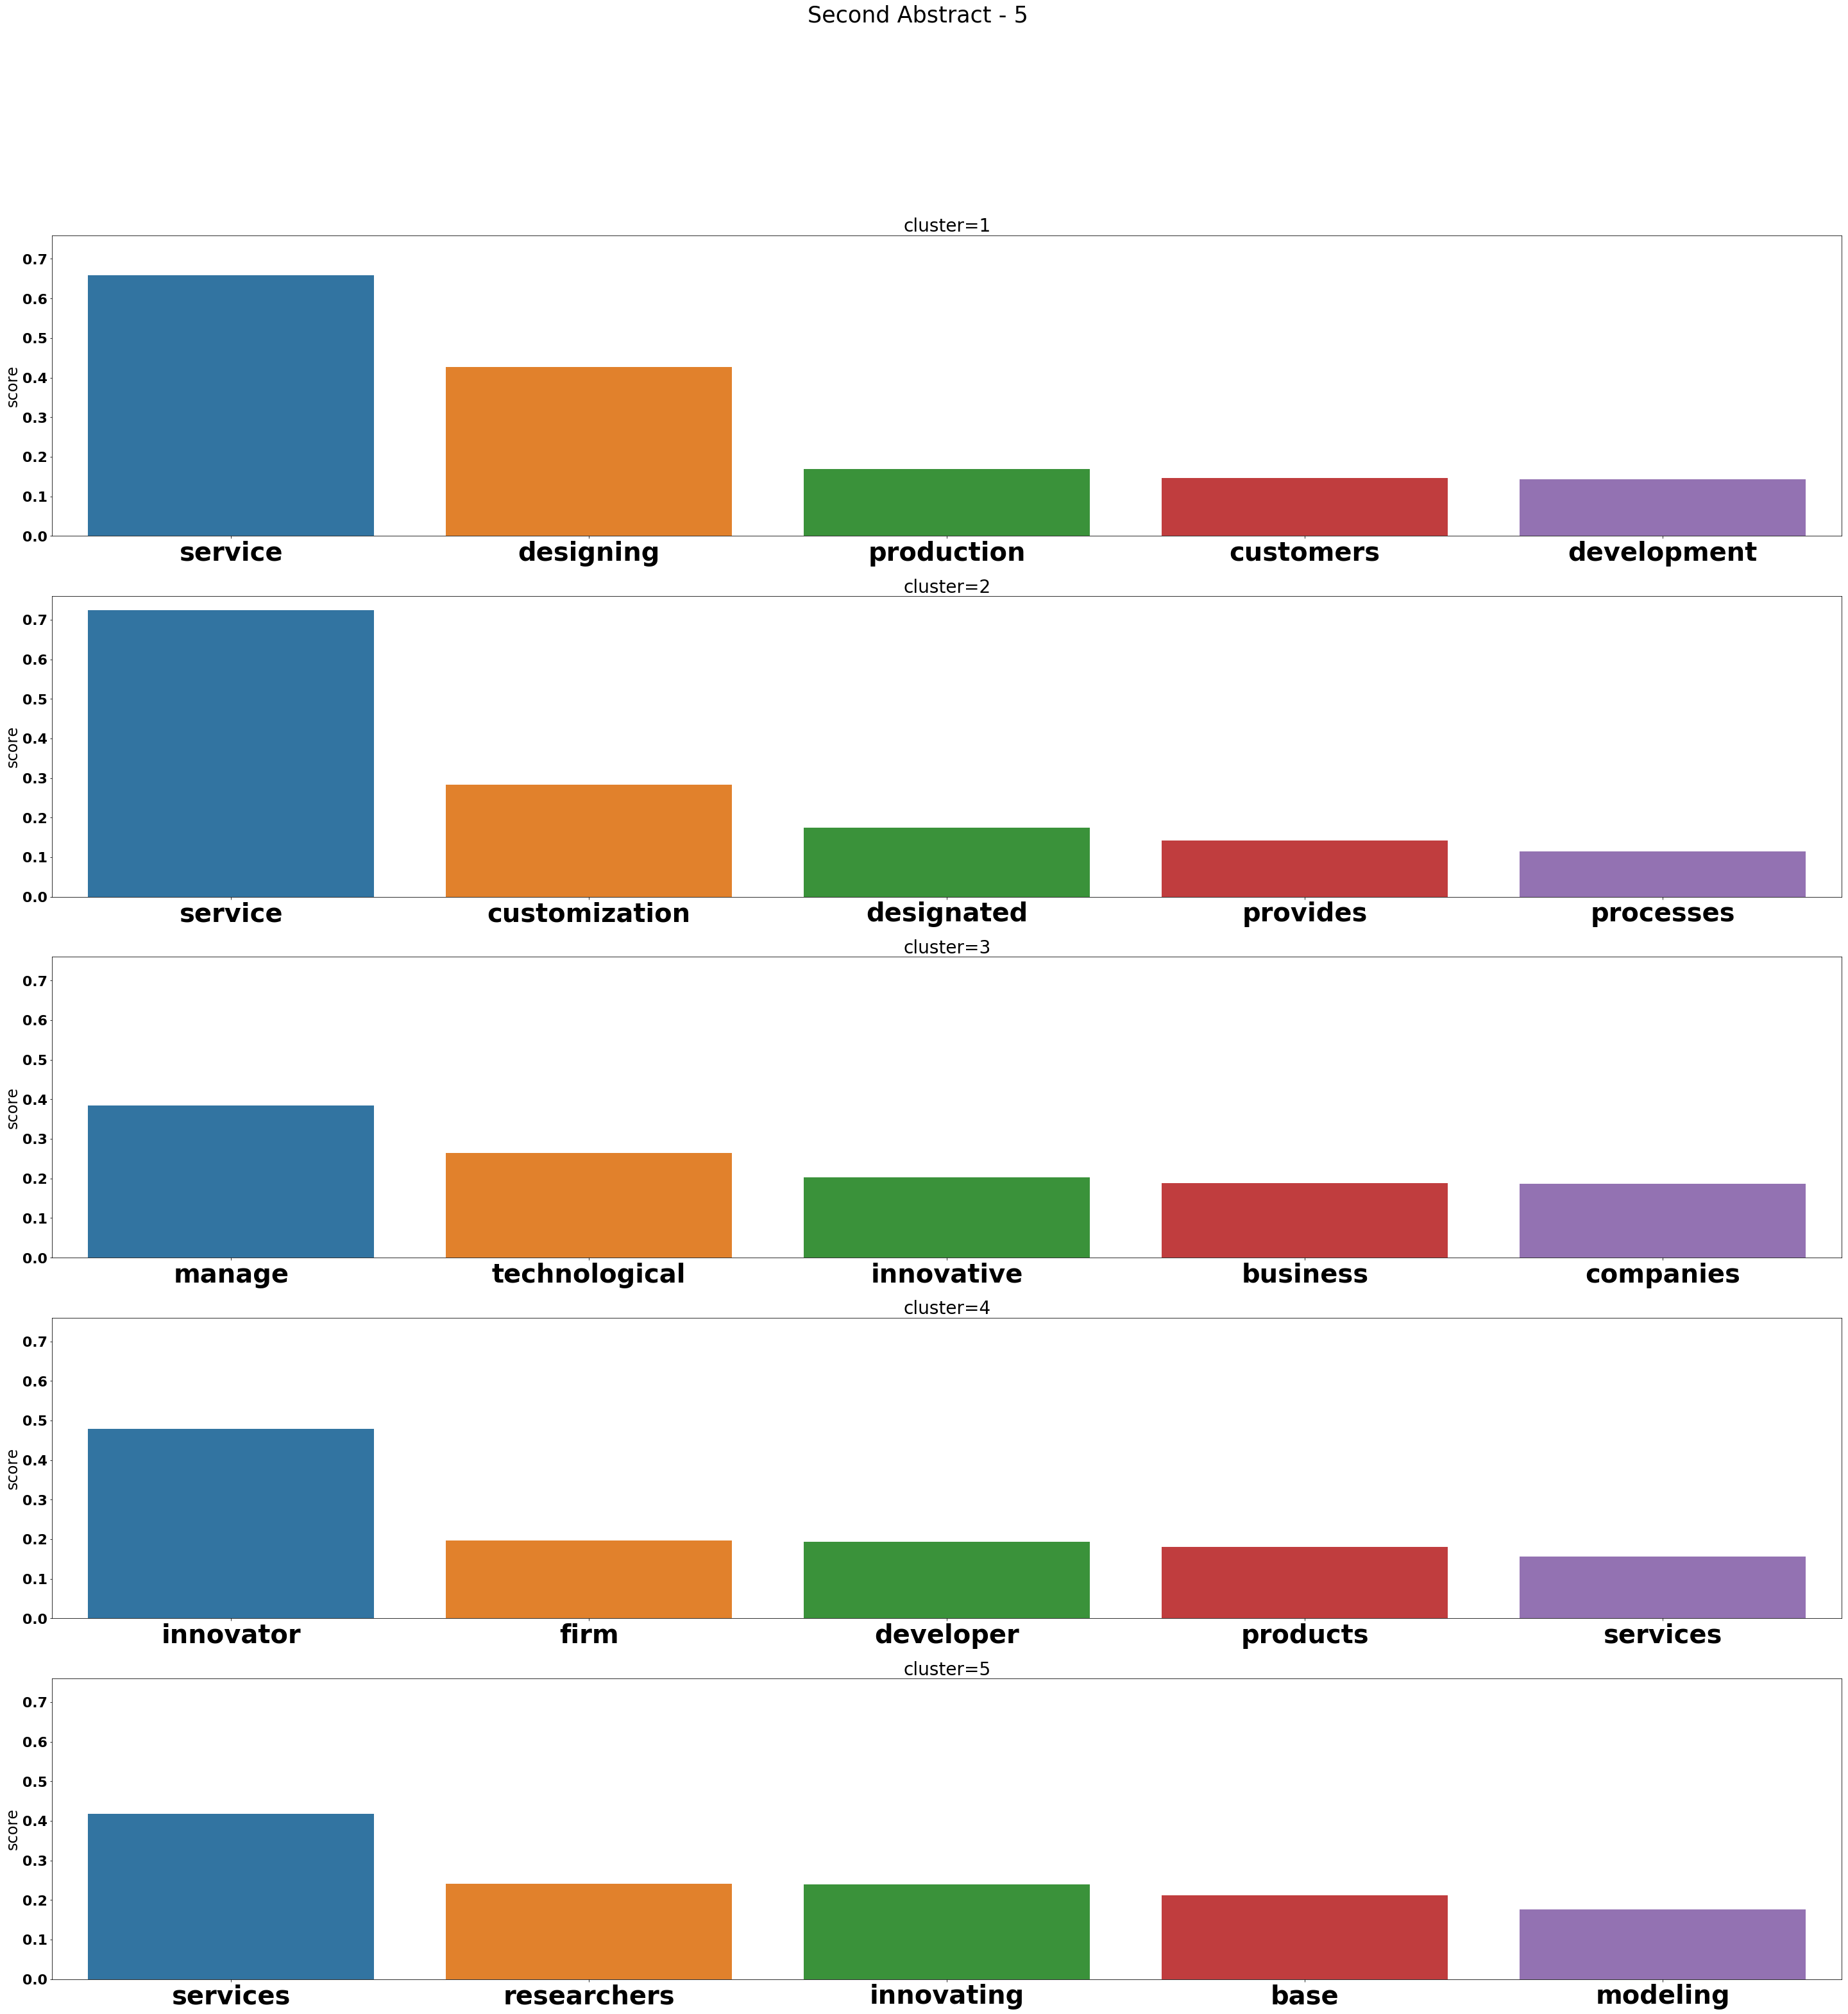

In [114]:
plot_cluster_keywords(abstract_df, 5, "Second Abstract - 5")

In [136]:
pd.DataFrame.from_dict({"Paper": reference_rows, "Cluster5": c5, "Cluster6": c6, "Cluster7": c7}).to_csv("data/second_abstracts_cluser.csv")